# Drinking and Heroin: Is there really a relationship?

*Data Collection from NSDUH for 2017*

Heroin and alcohol are two of the most abused substances in the US. Heroin is a powerful non-medically prescribed opiod drug in the US. Given the current opiod epidemic, which is now a national health crisis, the aim of this project is to determine whether there’s a relationship between yearly heroin consumption and yearly alcohol consumption. With that said, the question under evaluation is the following: if you know someone’s heroin consumption, can you predict their alcohol consumption. If such relationship exists, potential questions that may further be instigated is the likely hood of someone abusing heroin given their abuse of alcohol.




In [1]:
import numpy as np
import pandas as pd
import thinkstats2
import thinkplot
import matplotlib.pyplot as plt
# import plotly as py
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import linregress

## Data Collection and Exploration

In [2]:
datapath32 = "/Users/daphka/Google Drive/ThinkStats2/project1/NSDUH DATA/NSDUH-2017-DS0001-bndl-data-stata/NSDUH_2017.DTA"
df2017 = pd.read_stata(datapath32, convert_categoricals=False)

In [3]:
data = df2017
len(data)

56276

## Analyzing Demographics

Let's look at the breakdown of the age groups in the survey.

In [4]:
age = data["catage"]
age.value_counts()/len(age)

4    0.354112
2    0.245931
1    0.243834
3    0.156123
Name: catage, dtype: float64

In summary, we get the breakdown of age to be:
* 35.4% were between the age of 12-17
* 24.5% between the age of 18-25
* 24.3% between the age of 26-34
* 15.6% were 35 and above


This breakdown can be illustrated by a bar graph.

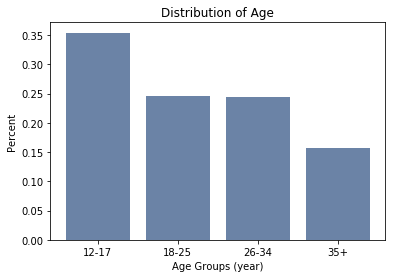

In [5]:
thinkplot.Bar(["12-17", "18-25", "26-34", "35+"], age.value_counts()/len(age))
thinkplot.Config(title= "Distribution of Age", xlabel = "Age Groups (year)", ylabel = "Percent")


Now we will look at the break down of race!

In [6]:
race = data["NEWRACE2"]
race.value_counts()/len(race)

1    0.588475
7    0.181534
2    0.125222
5    0.046752
6    0.038364
3    0.015033
4    0.004620
Name: NEWRACE2, dtype: float64

In summary, the breakdown of race is the following:
* 58.8% Caucasian
* 18.1% Hispanic
* 12.5% Black or African American
* 4.6% Asian
* 1.5% Native American and AK Natives
* 0.6% HI/Pacific Islander
* 3.8% more than one race


Here's a bar graph representing the break down of 

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

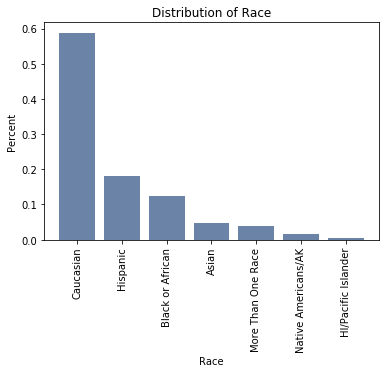

In [7]:
thinkplot.Bar(["Caucasian", "Hispanic", "Black or African", "Asian", "More Than One Race", "Native Americans/AK", "HI/Pacific Islander"], race.value_counts()/len(race))
thinkplot.Config(xlabel = "Race", ylabel = "Percent", title = "Distribution of Race")
plt.xticks(rotation="vertical")

Finally, we will look at the breakdown of respondent's education.

In [8]:
education = data["eduhighcat"]
education.value_counts()/len(education)

3    0.253892
5    0.243834
4    0.206162
2    0.200245
1    0.095867
Name: eduhighcat, dtype: float64

In summary, we get the following:
* 9.59% Less high school
* 20.0% High school grad
* 25.3% Some coll/Assoc Dg
* 20.6% College graduate
* 24.38% 12 to 17 year olds

Here's a bar graph to display the distribution of education.

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

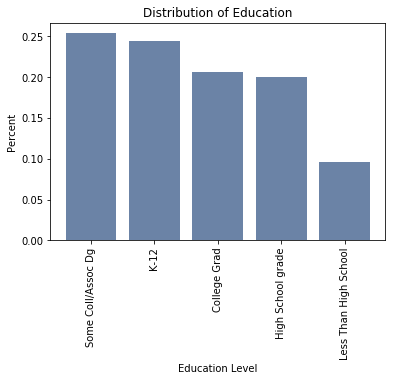

In [9]:
thinkplot.Bar(["Some Coll/Assoc Dg","K-12", "College Grad", "High School grade", "Less Than High School"], education.value_counts()/len(education))
thinkplot.Config(xlabel = "Education Level", ylabel = "Percent", title = "Distribution of Education")
plt.xticks(rotation="vertical")

## Analyzing variables: "alcyrtot" and "heryrtot"
* alcyrtot: reports the alcohol consumption of a respondent over the  past 12 months or 365 days
* heryrtot: reports the heroin consumption of a respondent over the  past 12 months or 365 days

### alcyrtot: Past 12 months of alcohol use

Let's look into the variable "alcyrtot". But first, we'll remove the non-quantitative variables with nan values.

In [10]:
data["alcyrtot"].replace([985, 991, 993, 994, 997, 998], np.nan, inplace=True)
data["heryrtot"].replace([985, 991, 993, 994, 997, 998], np.nan, inplace=True)


Now we will drop the nan values to do some analysis on the distribution of the data reported.

In [11]:
alcoholUsedPast12MO = data["alcyrtot"].dropna()
alcoholUsedPast12MO.skew()

1.3839023388653218

<h3>Summary Statistics</h3>

We will be using Histogram to see the shape of the distribution of alcohol consumption.

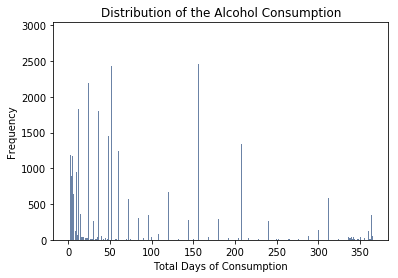

In [12]:
alcoholUsedPast12MOHist = thinkstats2.Hist(alcoholUsedPast12MO)
thinkplot.Hist(alcoholUsedPast12MOHist)
thinkplot.Config(xlabel = "Total Days of Consumption", ylabel = "Frequency", title = "Distribution of the Alcohol Consumption")

As can be observed in this histogram, the share of the distribution of alcohol consumption can be described as being multimodal, asymmetric and right-skewed.

Another way of visualizing the distribution of this variable is with its probability mass function.

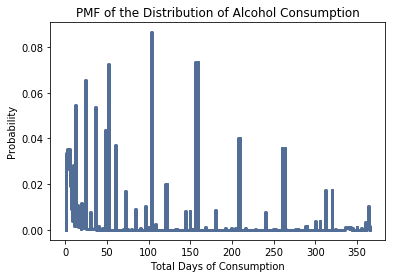

In [13]:
alcoholUsedPast12MOPmf = thinkstats2.Pmf(alcoholUsedPast12MO)
thinkplot.Pmf(alcoholUsedPast12MOPmf)
thinkplot.Config(xlabel = "Total Days of Consumption", ylabel = "Probability", title = "PMF of the Distribution of Alcohol Consumption")

As can be observed, this probability mass function looks similar to the histogram and it doesn't really tell us more than we had already observed.

Can the Cumulative Distribution Function tell us a little more about our distribution from a more analytical perspective?

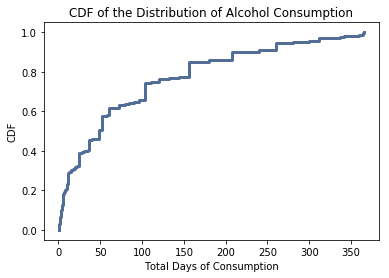

In [14]:
alcoholUsedPast12MOCdf = thinkstats2.Cdf(alcoholUsedPast12MO)
thinkplot.Cdf(alcoholUsedPast12MOCdf)
thinkplot.Config(xlabel = "Total Days of Consumption", ylabel = "CDF", title = "CDF of the Distribution of Alcohol Consumption")

Based on the shape of the CDF, we can hypothesize that the distribution of alcohol consumption looks very similar to to the weibull analytic distribution model. Can we confirm this hypothesis? We will compare our distribution to a series of analytic distribution to determine if they can be modeled by any of the well-known distribution models.

The following functions allow you to plot the CDF of the distribution of alcohol consumption against a Gausian model as well as looking at the Normal Plot to confirm from if the model fits well.

In [15]:
def MakeNormalModel(values, label=''):
    """Plots a CDF with a Normal model.

    values: sequence
    """
    cdf = thinkstats2.Cdf(values, label=label) #plots percentile of values

    mean, var = thinkstats2.TrimmedMeanVar(values)
    std = np.sqrt(var)
    print('n, mean, std', len(values), mean, std)

    xmin = mean - 4 * std
    xmax = mean + 4 * std

    xs, ps = thinkstats2.RenderNormalCdf(mean, std, xmin, xmax)
    thinkplot.Plot(xs, ps, label='model', linewidth=4, color='0.8')
    thinkplot.Cdf(cdf)

In [16]:
def MakeNormalPlot(values, label=''):
    """Generates a normal probability plot.

    values: sequence
    """
    mean, var = thinkstats2.TrimmedMeanVar(values, p=0.01)
    std = np.sqrt(var)

    xs = [-5, 5]
    xs, ys = thinkstats2.FitLine(xs, mean, std)
    thinkplot.Plot(xs, ys, color='0.8', label='model')

    xs, ys = thinkstats2.NormalProbability(values)
    thinkplot.Plot(xs, ys, '+', alpha=0.3, label=label)

n, mean, std 33532 80.33293773963848 87.3373488181064


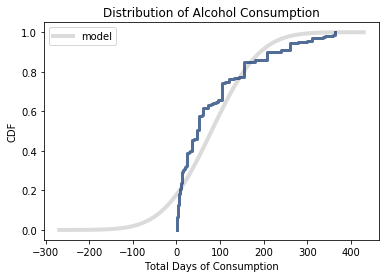

In [31]:
MakeNormalModel(alcoholUsedPast12MO, label='')

thinkplot.Config(title='Distribution of Alcohol Consumption', 
         xlabel='Total Days of Consumption', 
         ylabel='CDF')

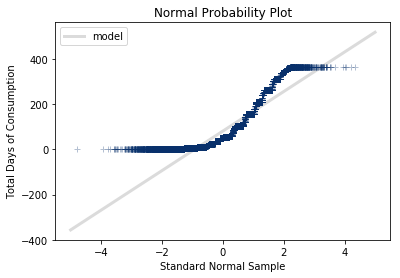

In [33]:
MakeNormalPlot(alcoholUsedPast12MO, label='')

thinkplot.Config(title='Normal Probability Plot', 
         xlabel='Standard Normal Sample', 
         ylabel='Total Days of Consumption')

Both the Gaussian CDF and Normal Sample Plot has shown that the data cannot be modeled using a Gaussian analytic model. So can it be modeled using an exponential analytic distribution?

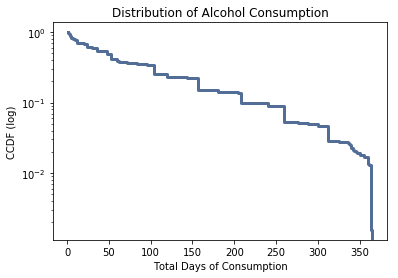

In [34]:
thinkplot.Cdf(alcoholUsedPast12MOCdf, complement=True)
thinkplot.Config(title='Distribution of Alcohol Consumption', 
         xlabel='Total Days of Consumption', 
         ylabel='CCDF (log)',
         yscale = "log")

While the CCDF shows a somewhat linear pattern, which is an indication that the data could potentially be modeled using an exponential analytical distribution, there's a lot of constant intervals. Could there be a better fit?

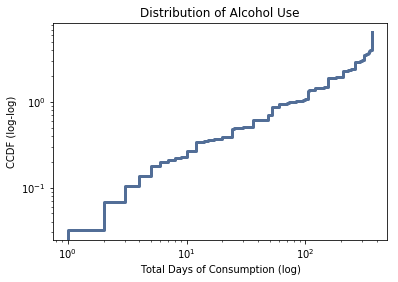

In [35]:
thinkplot.Cdf(alcoholUsedPast12MOCdf, transform = "weibull")
thinkplot.Config(title = "Distribution of Alcohol Use",
                 xlabel = "Total Days of Consumption (log)",
                 ylabel = "CCDF (log-log)",
                 yscale = "log", xscale = "log")

Plotting this distribution on a log-log y scale and a log x scale, we can see the linear pattern of a typical weibull distribution. This is another confirmation that the data could be modeled using an exponential distribution since exponential distributions are a special case of weibull. Exponential Distributions typically measure the interarrival time between events of a random variable. In this case, we are measuring the number of days (time) of alcohol consumption which is also a random variable that can take values between 0 - 365 days, making the exponential model a good fit for our dataset.

In [21]:
alcoholUsedPast12MO.describe()

count    33532.000000
mean        82.375880
std         91.318878
min          1.000000
25%         12.000000
50%         48.000000
75%        120.000000
max        365.000000
Name: alcyrtot, dtype: float64

Lastly by looking at the summary statistics, we can numerically characterize the center and variation of the distribution of alcohol consumption. It is noted that the mean of alcohol consumption over 12 months is 82.4 days and the median is 48 days. Another observations that can be made using the median value which means that 50% of the observations fall below or are equal to 48.0 days is that a good portion of the observations are small, which is another characterization of a weibull distribution.

## heryrtot: Past 12 Months of Heroin Use

Now we will look into another variable "heryrtot" which looks at the distribution of heroin use over the past 12 months.

In [22]:
heroinUsedPast12MO = data["heryrtot"].dropna()
heroinUsedPast12MO.skew()

0.7344488836309345

We will now look at the histogram of "heryrtot" to get a good visualization of the distribution of the observations.

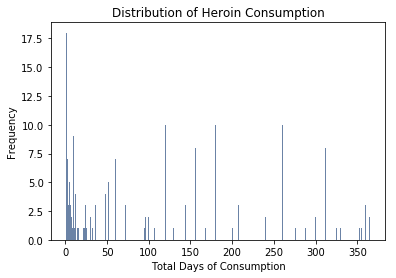

In [23]:
heroinUsedPast12MOHist = thinkstats2.Hist(heroinUsedPast12MO)
thinkplot.Hist(heroinUsedPast12MOHist)
thinkplot.Config(xlabel = "Total Days of Consumption", ylabel = "Frequency", title = "Distribution of Heroin Consumption")

Based on the graph, we can see that the shape of the distribution is multi-modal, asymmetric and right skewed, which is confirmed by the positive measure of skewness above. Due to the spread of the frequency bins, we can see that there's a lot of variability in the observations.

Can the probability mass function tell us more about this distribution?

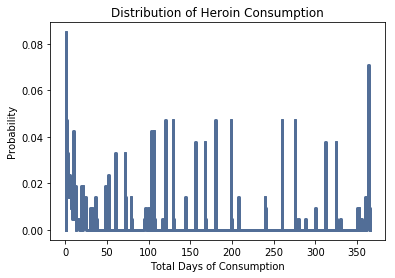

In [24]:
heroinUsedPast12MOPmf = thinkstats2.Pmf(heroinUsedPast12MO)
thinkplot.Pmf(heroinUsedPast12MOPmf)
thinkplot.Config(xlabel = "Total Days of Consumption", ylabel = "Probability", title = "Distribution of Heroin Consumption")

We observed the same shape for the probability of the values in the data set where there's a high concentration of small values around the tens and large values around 360 days.

What about the Cumulative Distribution Function?

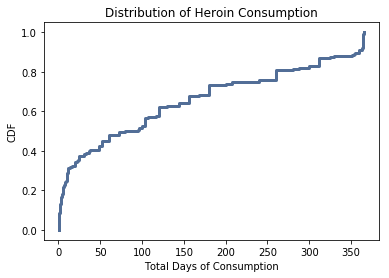

In [25]:
heroinUsedPast12MOCdf = thinkstats2.Cdf(heroinUsedPast12MO)
thinkplot.Cdf(heroinUsedPast12MOCdf)
thinkplot.Config(xlabel = "Total Days of Consumption", ylabel="CDF", title = "Distribution of Heroin Consumption")

Given that we're measuring time, we see that the CDF looks very similar to the distribution of alcohol consumption. Therefore, we can hypothesize that the dataset can be modeled using an exponential/weibul distribution. To confirm this, we will plot the distribution against different scales that will easily tell us if that's true.

In this plot, we look at the CCDF on a log y scale and we expect to see a linear pattern if the data can be modeled using an exponential distribution.

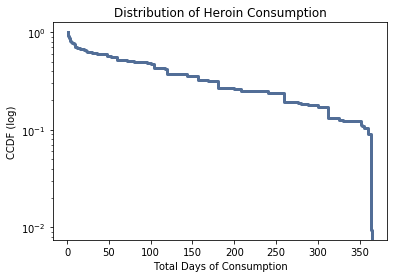

In [36]:
thinkplot.Cdf(heroinUsedPast12MOCdf, complement=True, label='')
thinkplot.Config(xlabel="Total Days of Consumption", ylabel = "CCDF (log)", title = "Distribution of Heroin Consumption", yscale='log')

For the most part, we can see that the data takes on a linear pattern, a marker that it can modeled using an exponential analytical distribution.

Next, we plot it using a weibull transformation to see the CCDF on a log-log(y) scale and a log(x) scale.

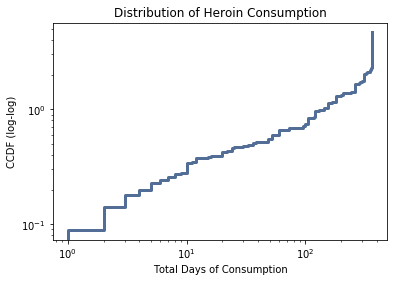

In [37]:
thinkplot.Cdf(heroinUsedPast12MOCdf, transform = "weibull")
thinkplot.Config(title = "Distribution of Heroin Consumption",
                 xlabel = "Total Days of Consumption", 
                 ylabel = "CCDF (log-log)",
                 yscale = "log", xscale = "log")

Again, we see that the data is linear, another confirmation that the exponential/weibull distribution might be a great fit for our dataset.

In [38]:
heroinUsedPast12MO.describe()

count    212.000000
mean     125.066038
std      128.519331
min        1.000000
25%       10.000000
50%       87.500000
75%      216.000000
max      365.000000
Name: heryrtot, dtype: float64

# Correlation Analysis

## Scatterplot and Linear Regression

Now we will plot the two variables on a scatterplot to see if there exists a linear relationship between them. 

In [39]:
alcoholUsedPast12MONAN = data["alcyrtot"]
heroinUsedPast12MONAN = data["heryrtot"]
len(alcoholUsedPast12MONAN), len(heroinUsedPast12MONAN)

(56276, 56276)

LinregressResult(slope=-0.27983148967809446, intercept=140.3996268371461, rvalue=-0.22416009409678647, pvalue=0.003907859976324315, stderr=0.09558416331698188)

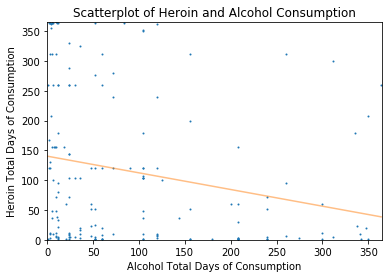

In [40]:
plt.plot(alcoholUsedPast12MONAN, heroinUsedPast12MONAN, 'o', markersize =1)

plt.title("Scatterplot of Heroin and Alcohol Consumption")
plt.xlabel('Alcohol Total Days of Consumption')
plt.ylabel('Heroin Total Days of Consumption')
plt.axis([0, 365, 0, 365]);



subset = data.dropna(subset=['alcyrtot', 'heryrtot']) #drops nan from multiple columns using subset as a parameter of dropna()

xs = subset["alcyrtot"] #x-values
ys = subset["heryrtot"]#y-values

res = linregress(xs, ys) #LSE - minimizes the error

# plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-', alpha=0.5)
res

As you can see there's a weak negative correlation between the two variables. The scatterplot shows that most people who consume alcohol don't typically consume heroin because all the points are fall along the axis of the two variables. Very few points demonstrate the linear relationship between the two. The correlation coefficient is -0.28 and the p-value is 0.003 with a standard error of 0.1.